In [5]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pyaudio
import glob
import IPython.display as ipd
import librosa
import librosa.display


plt.rcParams['figure.figsize'] = [15, 8]

root_path = '/home/kvattis/Desktop/data/'
root_path = ""
sess_name = 'AG4__sit_to_stand_task' # 'AG4__DSC_task' 'AG4__mouse_task' 'AG4__pursuit_task' 'AG4__sit_to_stand_task'

file = root_path +  sess_name + ".xdf"
vids_bio = glob.glob(root_path + sess_name.replace("__", "_") + "*.avi")
vids_intel = glob.glob(root_path + sess_name.replace("__", "_") + "*.bag")

In [6]:
print("Brios: = ")
_ = [print("\t" + v) for v in vids_bio] if len(vids_bio) else print("\tNone")
print("Intel: = ")
_ = [print("\t" + v) for v in vids_intel] if len(vids_intel) else print("\tNone")

Brios: = 
	None
Intel: = 
	AG4_sit_to_stand_task_intel2_1627400636.2494135.bag
	AG4_sit_to_stand_task_intel3_1627400637.397702.bag


In [7]:
# Print date

from datetime import datetime

if len(vids_bio):
    tstamp = float(vids_bio[0].split("_")[-1].replace(".avi", ""))
elif len(vids_intel):
    tstamp = float(vids_intel[0].split("_")[-1].replace(".bag", ""))
    
dt_object = datetime.fromtimestamp(tstamp)

print("Date recorded:", dt_object)



Date recorded: 2021-07-27 11:43:56.249413


In [62]:

def read_vid(cap):
    vid_mat = []    
    f_num = 0
    while True:
        ret, frame = cap.read()        
        if not ret:
            break
        # vid_mat.append(np.average(frame,2))
        vid_mat.append(np.average(frame))        
        f_num += 1
        
    # vid_mat = np.stack(vid_mat, 2)    
    return vid_mat#, f_num

    
def plot_frames(vid_mat_list, frame_nums):
    
    n_cams = len(vid_mat_list)
    fig, axs = plt.subplots(1, n_cams)
    
    for ax, cap, frame_num in zip(axs, vid_mat_list, frame_nums):
        frame = cap[:,:, frame_num]
        ax.imshow(frame)

    
def plot_averg(vid_crp_list, frame_events_list):
    
    n_cams = len(vid_crp_list)
    fig, axs = plt.subplots(n_cams,1)
    
    for ax, cap, evts in zip(axs, vid_crp_list, frame_events_list):
        cap_m =cap # np.mean(cap,(0,1))  
        for ev in evts:
            ax.axvline(ev)
            
        ax.plot(cap_m, ".-", color='r')
            

def find_closest(marker_stmp, vid_stmps):
   inx =  np.argmin(np.abs(vid_stmps['time_stamps'] - marker_stmp))
   if vid_stmps['time_series'].shape[1]> 1:
        frame_num = vid_stmps['time_series'][inx,0]
   else:
        frame_num, = vid_stmps['time_series'][inx]
   return int(frame_num)

    
def sound(array, fs=43):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=len(array.shape), rate=fs, output=True)
    stream.write(array.tobytes())
    stream.stop_stream()
    stream.close()
    p.terminate()
    
def record(duration=3, fs=44100):
    nsamples = duration*fs
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=fs, input=True,
                    frames_per_buffer=nsamples)
    buffer = stream.read(nsamples)
    array = np.frombuffer(buffer, dtype='int16')
    stream.stop_stream()
    stream.close()
    p.terminate()
    return array


Stream 1: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.


EyeLink samples:0
Mouse samples:0
Marker samples:4, duration: 29.022472600103356, fps:0.13782423210852665
mbient_RH samples:4963, duration: 49.02717069999926, fps:101.22958206927643
Audio samples:2111, duration: 49.01796150000155, fps:43.065846383675776
IntelFrameIndex_cam3 samples:2669, duration: 44.0242889000001, fps:60.62562432439412
mbient_LH samples:4596, duration: 49.019974800001364, fps:93.75769813736974
IntelFrameIndex_cam1 samples:2674, duration: 44.02696900000592, fps:60.73550055193762
IntelFrameIndex_cam2 samples:2669, duration: 44.02401139999711, fps:60.62600647064559


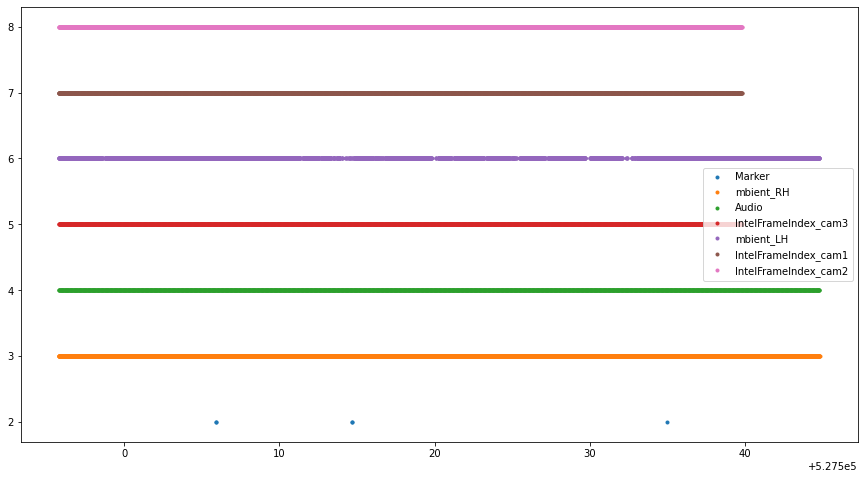

In [22]:

data, header = pyxdf.load_xdf(file)
has_marker = False
cams, intels = {}, {}
plt.figure()
for i, d in enumerate(data):
    name = d['info']['name'][0]
    
    if d['time_stamps'].size == 0 :
        print(f"{name} samples:0")
        continue
    
    if d['info']['name'][0] == 'Marker':
        has_marker = True
        markers = d
    elif d['info']['name'][0][:4] == 'Brio':
        cname = f"brio{d['info']['name'][0][-1]}"
        cams[cname] = d
    elif d['info']['name'][0][:5] == 'Intel':
        cname = f"intel{d['info']['name'][0][-1]}"
        intels[cname] = d          
    elif d['info']['name'][0] == 'Tobii':
        tobii = d
    elif d['info']['name'][0] == 'Audio':
        audio = d        
    elif d['info']['name'][0] == 'Mouse':
        mouse = d       
        
    ts1, = d['footer']['info']['last_timestamp']
    ts0, = d['footer']['info']['first_timestamp']
    # ts0 = d['time_stamps'][2]
    # ts1 = d['time_stamps'][-1]
    tsn, = d['footer']['info']['sample_count']
    duration = float(ts1)-float(ts0)
    fps = 0 if int(tsn)==0 else int(tsn)/duration
    print(f"{name} samples:{tsn}, duration: {duration}, fps:{fps}")
    tmst = d['time_stamps']
    plt.plot(tmst, [i]*len(tmst), ".", label=name)
plt.legend()


  


Plotting time series


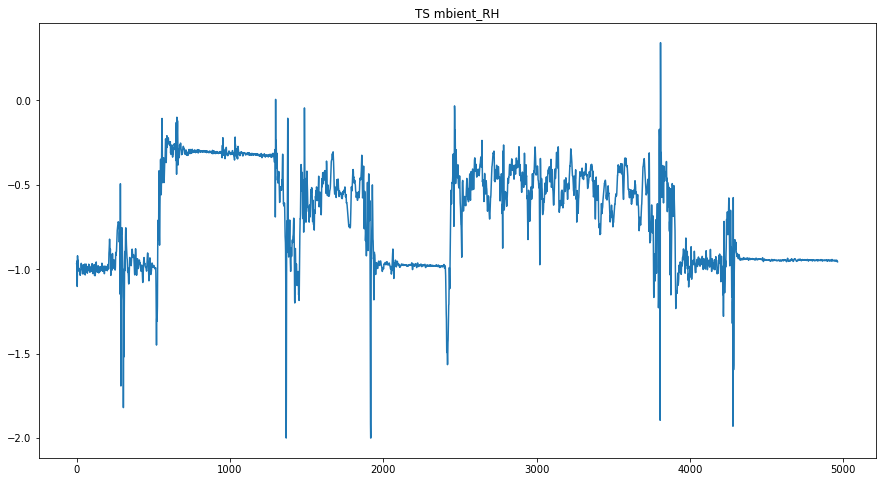

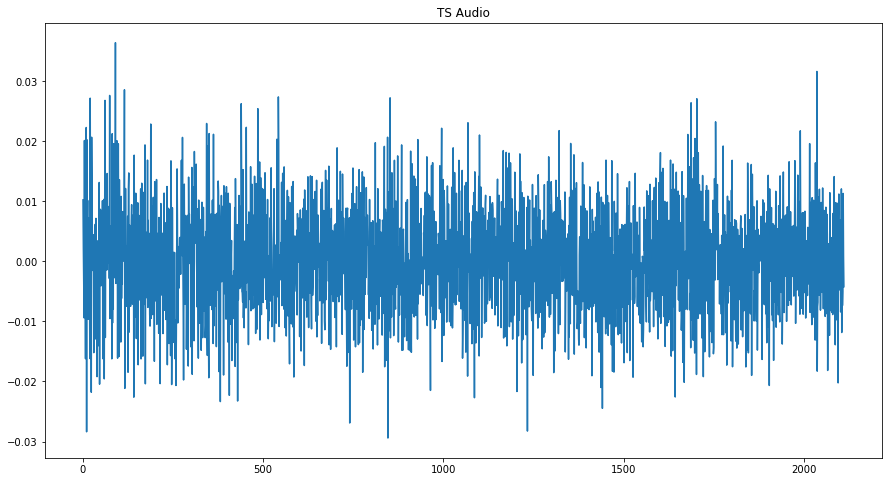

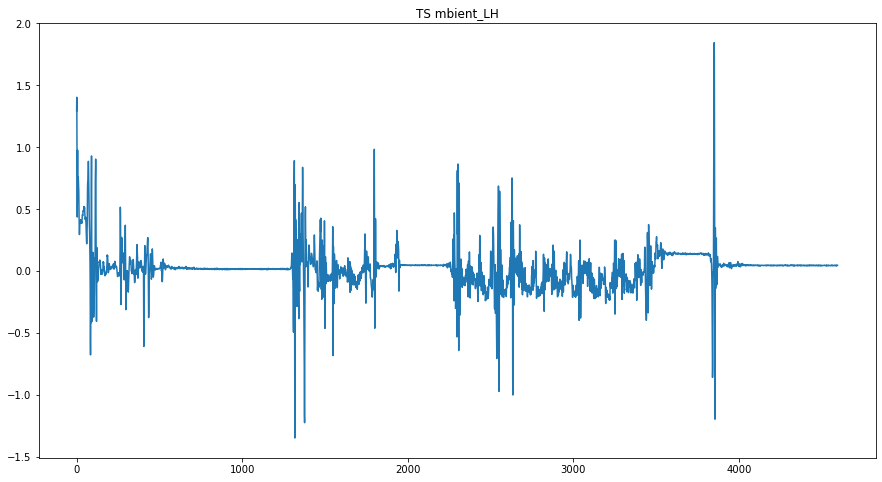

In [27]:

print("Plotting time series")
for i, d in enumerate(data):
    name = d['info']['name'][0]
    if name[:4] in ["Mark","Inte", "Brio"] :
        continue
    if d['time_stamps'].size == 0 :
        continue
        
    plt.figure()
    plt.title(f"TS {name}")
    tt = d['time_stamps']
    ts = d['time_series']
    if not isinstance(ts, list) and ts.shape[1]> 1:
        ts = ts[:,0]
    
    if isinstance(ts, list):
        ts = np.array(ts)
    
    ts_f = ts.flatten("C")
    plt.plot(ts_f, label=name)
#     if has_marker:        
#         mrk = markers['time_stamps']
#         for mk in mrk:
#             plt.axvline(mk, color = "red", linestyle="--")

Plotting diff time stamps
EyeLink samples:0
Mouse samples:0


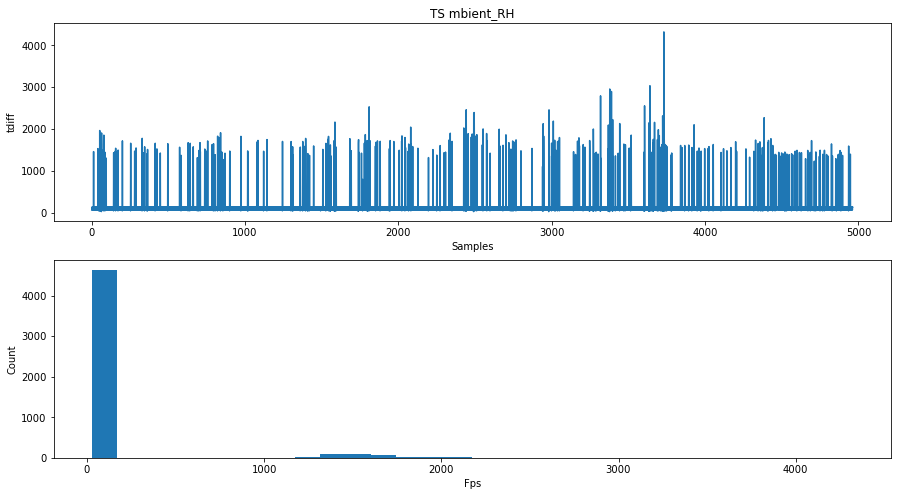

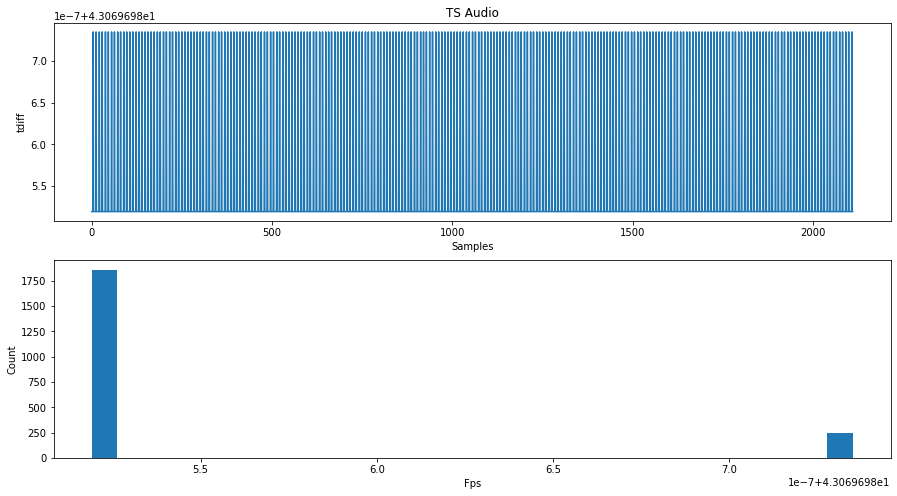

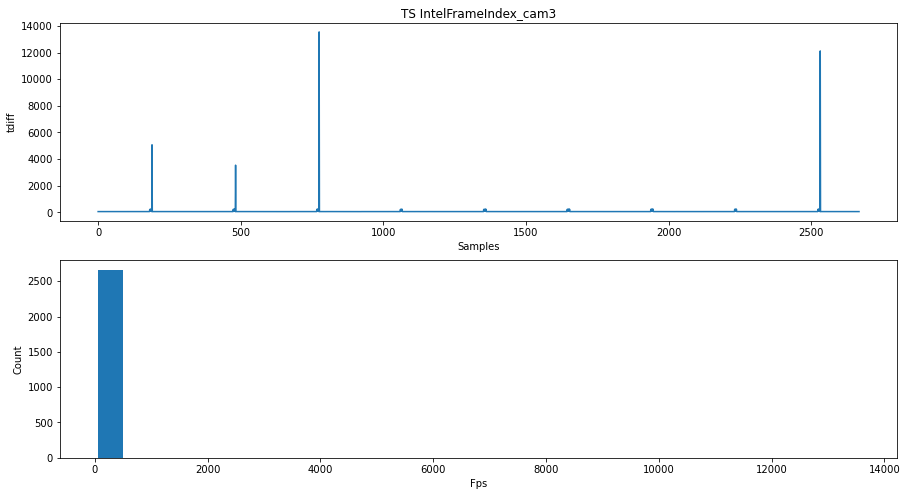

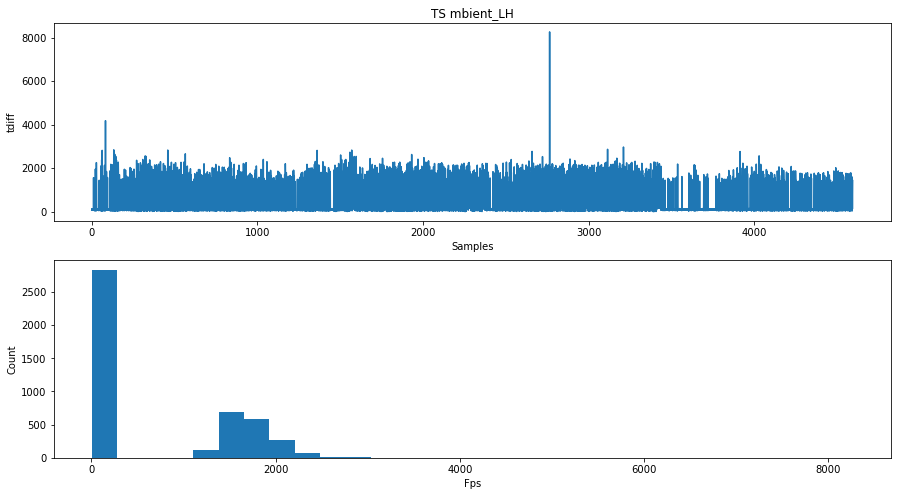

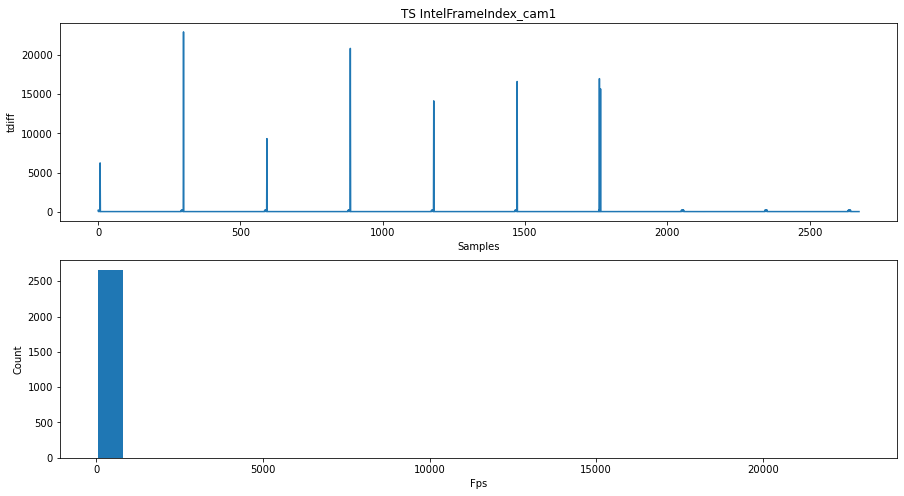

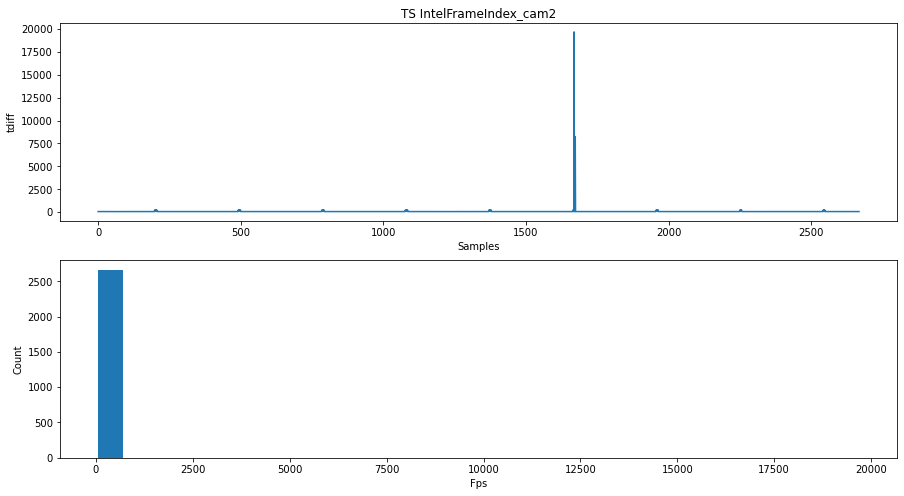

In [33]:
print("Plotting diff time stamps")
for i, d in enumerate(data):
    name, = d['info']['name']
    if name == "Marker":
        continue
        
    if d['time_stamps'].size == 0 :
        print(f"{name} samples:0")
        continue
        
    fig, ax = plt.subplots(2,1)
    ax[0].set_title(f"TS {name}")
    tt = np.diff(d['time_stamps'])
    
    ax[0].plot(1/tt)
    ax[0].set_xlabel("Samples")
    ax[0].set_ylabel("tdiff")
    ax[1].hist(1/tt, 30)
    ax[1].set_xlabel("Fps")
    ax[1].set_ylabel("Count")
    

Plotting: 
	 LSL sample index vs Intel frame index 
	 Intel frame diff

	 Intel frame diff hist 
	 LSL frame diff hist


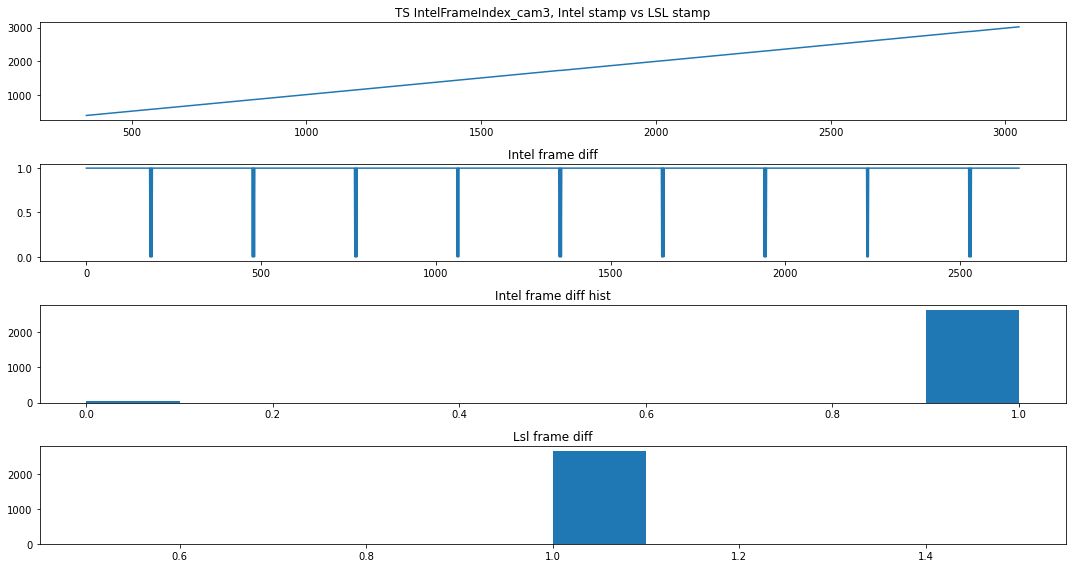

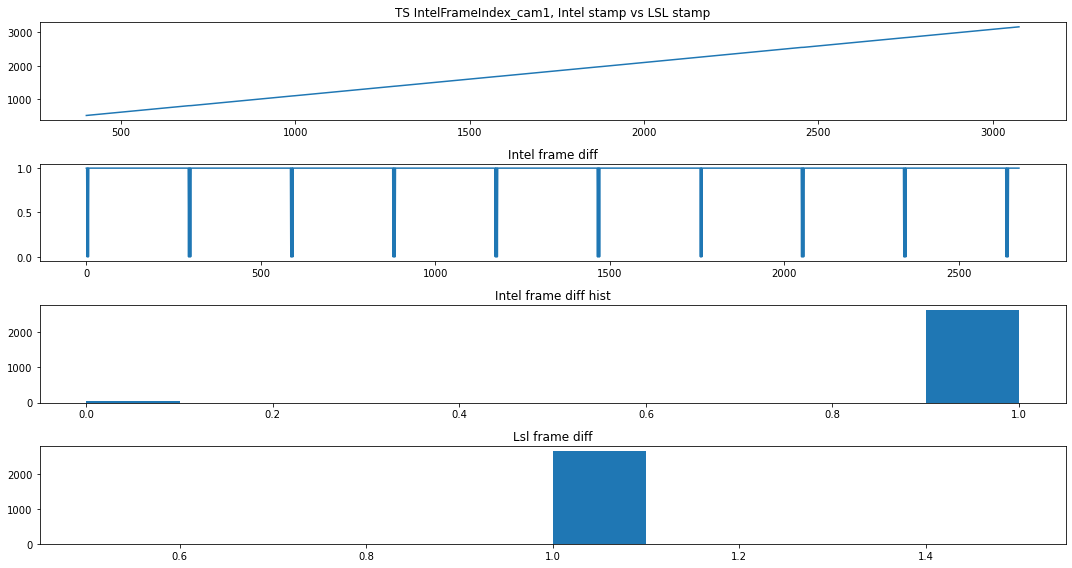

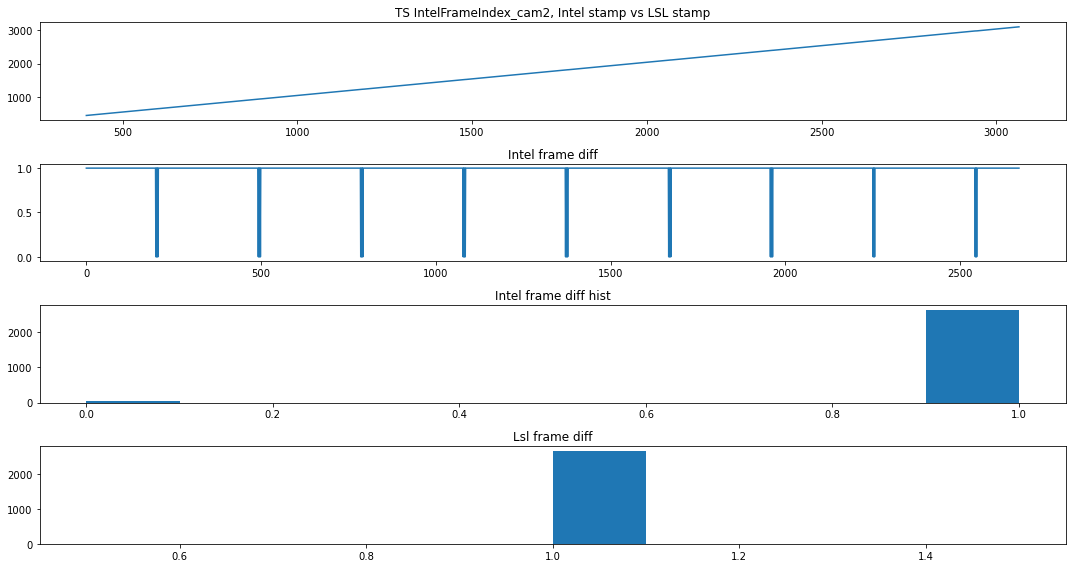

In [38]:
print("Plotting: \n\t LSL sample index vs Intel frame index \n\t Intel frame diff")
print("\n\t Intel frame diff hist \n\t LSL frame diff hist")
for i, d in enumerate(data):
    name = d['info']['name'][0]
    if name[:4]  != "Inte":
        continue
    inx_lsl  = d['time_series'][:,0]
    inx_int  = d['time_series'][:,1]
        
    fig, ax = plt.subplots(4,1)
    ax[0].set_title(f"TS {name}, Intel stamp vs LSL stamp")
    dif_int = np.diff(inx_int)
    dif_lsl = np.diff(inx_lsl)
    
    ax[0].plot(inx_lsl, inx_int)
    
    ax[1].set_title("Intel frame diff")
    ax[1].plot(dif_int)
    
    ax[2].set_title("Intel frame diff hist")
    ax[2].hist(dif_int)
    
    ax[3].set_title("Lsl frame diff")
    ax[3].hist(dif_lsl)    
    
    fig.tight_layout()

array([ -0.96868896,  -0.0244751 ,  -0.02526855,  -1.3414634 ,
       -16.219513  , -10.487805  ], dtype=float32)

Plotting diff time stamps


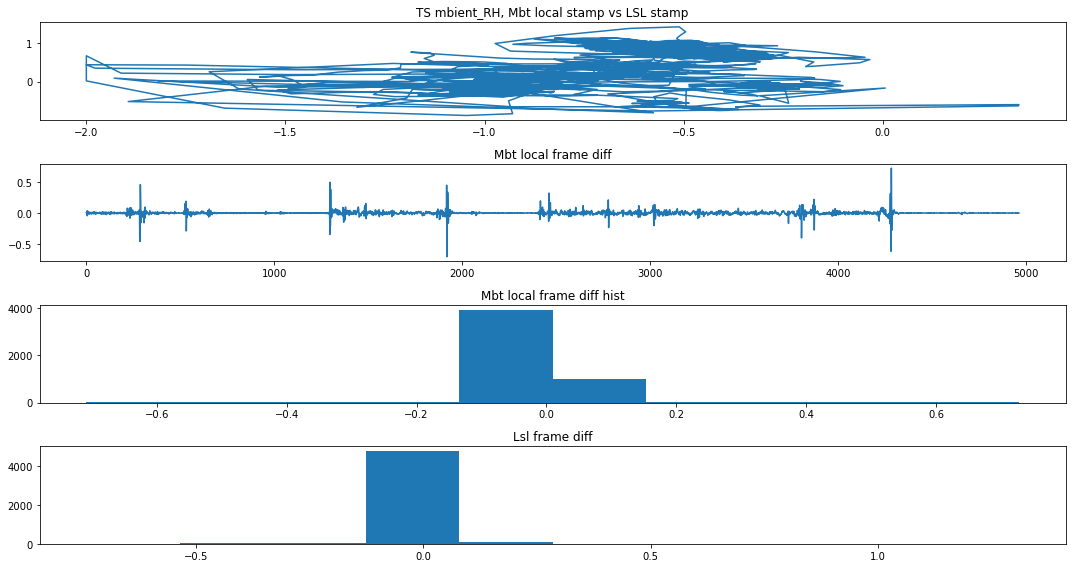

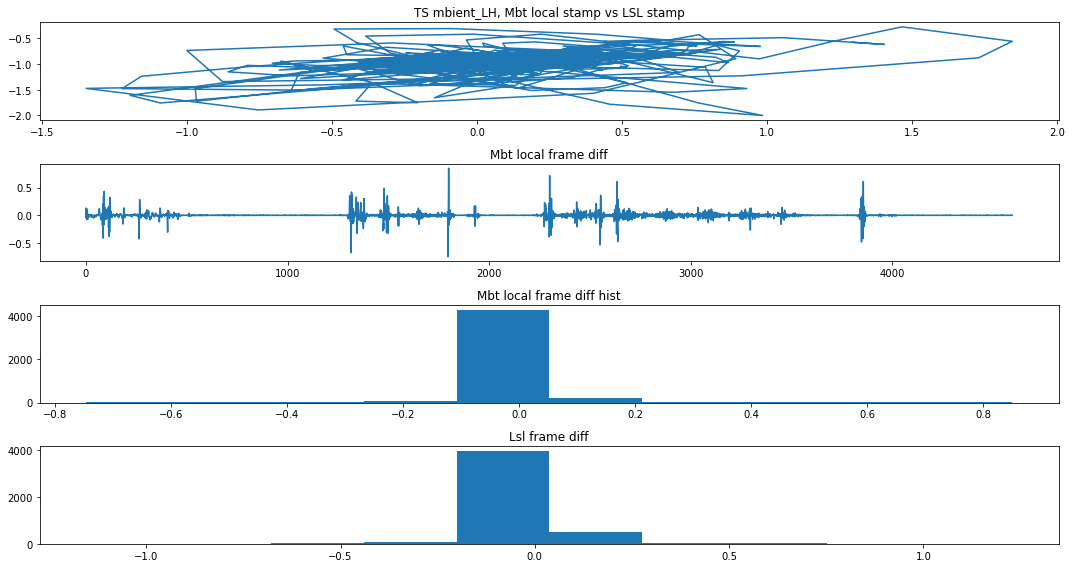

In [80]:
print("Plotting diff time stamps")
for i, d in enumerate(data):
    name, = d['info']['name']
    if "mbient" not in name:
        continue
 
    if d['time_stamps'].size == 0 :
        print(f"{name} samples:0")
        continue
        
    inx_lsl  = d['time_series'][:,0]
    inx_int  = d['time_series'][:,1]
        
    fig, ax = plt.subplots(4,1)
    ax[0].set_title(f"TS {name}, Mbt local stamp vs LSL stamp")
    dif_int = np.diff(inx_int)
    dif_lsl = np.diff(inx_lsl)
    
    ax[0].plot(inx_lsl, inx_int)
    
    ax[1].set_title("Mbt local frame diff")
    ax[1].plot(dif_int)
    
    ax[2].set_title("Mbt local frame diff hist")
    ax[2].hist(dif_int)
    
    ax[3].set_title("Lsl frame diff")
    ax[3].hist(dif_lsl)    
    
    fig.tight_layout()

print("Plotting: \n\t LSL sample index vs Intel frame index \n\t Intel frame diff")
print("\n\t Intel frame diff hist \n\t LSL frame diff hist")
for i, d in enumerate(data):
    name = d['info']['name'][0]
    if name[:4]  != "Xime":
        continue
    inx_lsl  = d['time_stamps']
    inx_int  = d['time_series'][:,1]

    inx_int = inx_int/1e9
    

    
    fig, ax = plt.subplots(2,1, sharex=True)
    
    dif_int = np.diff(inx_int)
    dif_lsl = np.diff(inx_lsl)
    
       
    mask = np.where(dif_int>-3)
    dif_int = dif_int[mask]
    print(np.argmin(dif_int), dif_int.shape)
    ax[0].set_title("Ximia cam ts diff")
    ax[0].hist(dif_int, 50)
    
    ax[1].set_title("Ximia ls ts diff")
    ax[1].hist(dif_lsl, 50)

    
    inx_int -= inx_int[0]
    inx_lsl -= inx_lsl[0] 
    inx_int = inx_int[mask]
    inx_lsl = inx_lsl[mask]
#     inx_lsl = inx_lsl[mask]
    
    fig, ax = plt.subplots(1, sharex=True)
    dd = inx_int - inx_lsl
    ax.plot(inx_int, inx_lsl)
    print(inx_int.shape, inx_lsl.shape)
#     ax.hist(dd, 50)    
    

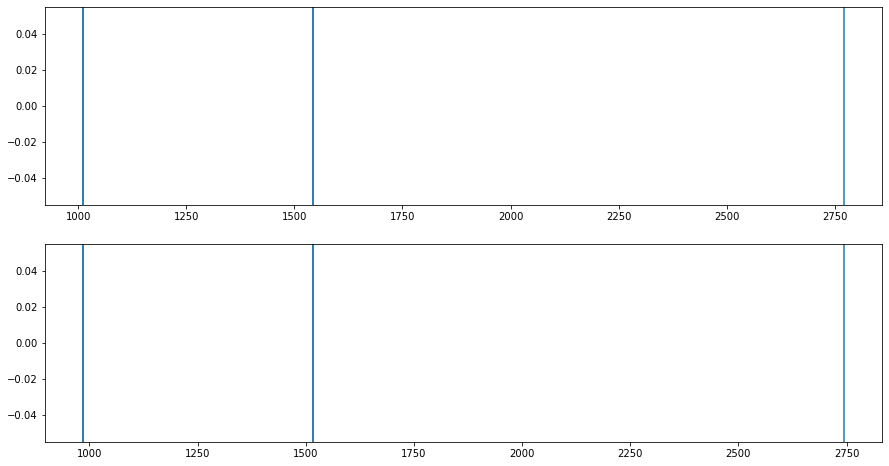

In [63]:
 
###############################################################################
## Video
####


caps = [cv2.VideoCapture(vid) for vid in vids_intel]
chinfs = [intels[vid.split("_")[-2]] for vid in vids_intel]

vid_mats = [read_vid(cap) for cap in caps]

frame_nums = [find_closest(markers['time_stamps'][0], caminf) for caminf in chinfs]

# plot_frames([vid_crp1, vid_crp2], frame_nums)
frm_events =  [ [find_closest(m, vid) for m in markers['time_stamps']] 
                for vid in chinfs ]
             
plot_averg(vid_mats, frm_events)



In [ ]:
###############################################################################
## Audio
####

evts = [np.argmin(np.abs(audio['time_stamps'] - e)) for e in  markers['time_stamps']]
audio_data =  np.hstack(audio['time_series'][evts[0]:, :])
plt.figure(), plt.plot( np.hstack(audio['time_series'][evts[0]:, :]))

_ = [plt.axvline((e-evts[0])*1024, color='r') for e in evts]

In [ ]:
ipd.Audio(audio_data, rate = 41000)

In [ ]:
n_fft = 2048 # time window size for FFT
n_mels = 64 # number of mel bands
hop_length = 1024 # Set the hop length; at 22050 Hz, 512 samples ~= 23ms
sampling_rate = 41000
#Going over all the files for the task
signal_, index = librosa.effects.trim(audio_data, top_db=15, frame_length=n_fft, hop_length=hop_length)

In [ ]:
#Compute the mel-scaled spectrogram in dB
S = librosa.feature.melspectrogram(signal_, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, window='hann')
S_dB = librosa.power_to_db(S, ref=np.max)

In [ ]:
librosa.display.specshow(S_dB, x_axis='s',y_axis='mel', sr=41000, hop_length= 160)

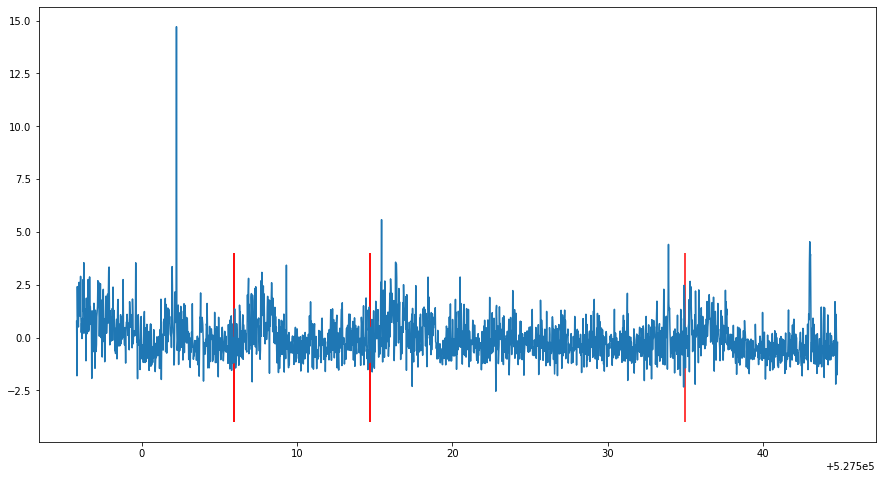

In [81]:

###############################################################################
# vids_arr = [(np.array(vid)[cam['time_series']], cam['time_stamps']) for vid, cam in zip(vid_mats, chinfs)]

# plt.figure(), 
# for vid in vids_arr:
#     plt.plot(vid[1], (vid[0] - vid[0].mean()) /vid[0].std())
 
audio_data =  audio['time_series'].max(1)
tsmp_a = audio['time_stamps']
tmax = len(audio_data)

plt.plot(tsmp_a[:tmax], (audio_data - audio_data.mean())/audio_data.std())

tt = markers['time_stamps']
plt.vlines(tt,-4, 4, "red")